## Evolution of a scalar wave equation in 1D

$$\dfrac{d\phi}{dt} = l$$

$$\dfrac{dl}{dt} = c^{2} \dfrac{d^2\phi}{dx^2}$$

With initial conditions:

$$ \phi(x,t) = \phi(x,0) = exp(-(x - 1)^2 / \sigma^2) $$

$$ \dfrac{d \phi}{dt} (x,0) = l(x,0) = 0 $$

and boundary conditions:

$$ \phi(x,t) = \phi(x + L,t), 0 \leq x \leq 2 $$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
#Physics
x_start = 0
x_length = 2.0
t_start = 0
t_end = 200
wave_speed = 1

In [3]:
Nx = 200 #+1 to include 0 as a point
Nghost = 2
#CFL condition: dt < alpha*dx/c
Courant_factor = 0.1

In [4]:
def compute_dt(cf,dx,c):
    dt = (cf*dx)/c
    return dt

In [5]:
dx = (x_start + x_length)/Nx
var_x = np.arange(x_start,x_start + x_length,dx) #End point not included for periodic/circular system
dt = compute_dt(Courant_factor,dx,wave_speed)
var_t = np.arange(t_start,t_end+dt,dt)
Nt = len(var_t)

In [6]:
# #Second order finite difference
# def second_derivative(var,dx):
#     D2_var = np.zeros(len(var))
#     var_with_ghosts = exterior_points(var)
#     for i in range (1,len(var_with_ghosts)-1): # calculates only interior
#         # Central finite difference method:
#         D2_var[i-1] = (var_with_ghosts[i-1] - 2*var_with_ghosts[i] + var_with_ghosts[i+1])/dx**2
#     return D2_var

# def exterior_points(var):
#     var_left_ghost = np.append(var[len(var)-1],var)
#     var_ghosts = np.append(var_left_ghost,var[0])
#     return var_ghosts

# Fourth order finite difference
#Ref: https://www.mech.kth.se/~ardeshir/courses/literature/fd.pdf
def second_derivative(var,dx):
    D2_var = np.zeros(Nx)
    var_with_ghosts = exterior_points(var)
    for i in range (2,len(var_with_ghosts)-2):
        # Central finite difference method:
        D2_var[i-2] = (-var_with_ghosts[i+2] + 16*var_with_ghosts[i+1] - 30*var_with_ghosts[i]
                       + 16*var_with_ghosts[i-1] - var_with_ghosts[i-2]  )/(12*dx**2)
    return D2_var

def exterior_points(var):
    var_l1_ghost = np.append(var[len(var)-1],var)
    var_l2_ghost = np.append(var[len(var)-2],var_l1_ghost)
    var_r1_ghost = np.append(var_l2_ghost,var[0])
    var_r2_ghost = np.append(var_r1_ghost,var[1])
    var_ghosts = var_r2_ghost
    return var_ghosts

In [7]:
def RK2(rhs,u_n,dt):
    k1 = np.array(rhs(u_n))
    k2 = np.array(rhs(u_n + (dt/2)*k1))
    u_np1 = u_n + dt*k2
    return u_np1

def RK4(rhs,u_n,dt):
    k1 = np.array(rhs(u_n))
    k2 = np.array(rhs(u_n + (dt/2)*k1))
    k3 = np.array(rhs(u_n + (dt/2)*k2))
    k4 = np.array(rhs(u_n + dt*k3))
    u_np1 = u_n + (dt/6)*(k1 + 2*k2 + 2*k3 + k4)
    return u_np1

In [8]:
def Evolve(init,rhs,time_integration_method,Nt,dt):
    u_0 = init()
    u_result = np.zeros((len(var_t),len(u_0),Nx)) #u_result[i][j][k]; i -> time, j-> variable, k-> x position
    print("Total iteration = %d"%(Nt-1))
    start_time = time.time()
    u_result[0] = np.array((u_0))
    for i in range (1,Nt):
        u_np1 = np.array(time_integration_method(rhs,u_0,dt))
        #store result of iteration
        u_result[i] = u_np1
        #update values
        u_0 = u_np1
    end_time = time.time()
    comp_time = end_time - start_time
    print("Computation time: %f seconds"%(comp_time))
    return u_result

In [9]:
#RHS expressions
def scalar_wave_RHS(u_n,dx):
    phi = u_n[0]
    l = u_n[1]
    phi_dot = l
    del_square_phi = second_derivative(phi,dx) #(variable,dx,degree of polynomial extrapolation)
    l_dot = (wave_speed**2)*del_square_phi    
    u_rhs = np.array((phi_dot,l_dot))
    return u_rhs

In [10]:
def initial_conditions(expr_phi,expr_l,dx):
    var_phi = expr_phi(var_x)
    var_l = expr_l(var_x)
    return var_phi,var_l

In [11]:
# Initial condition for phi at t=0
sigma = 0.1
expr_phi = lambda x: np.exp(-((x-1)/sigma)**2)
#Initial condition for d/dt(phi) = l at t=0
expr_l = lambda x: 0*x

In [12]:
#Evolve variables in time
u_result = Evolve(lambda: initial_conditions(expr_phi,expr_l,dx),
                  lambda u_n: scalar_wave_RHS(u_n,dx),
                  RK4,Nt,dt)

Total iteration = 200000
Computation time: 601.445077 seconds


In [13]:







#----------- End of numerical solution computation-----------------#








0


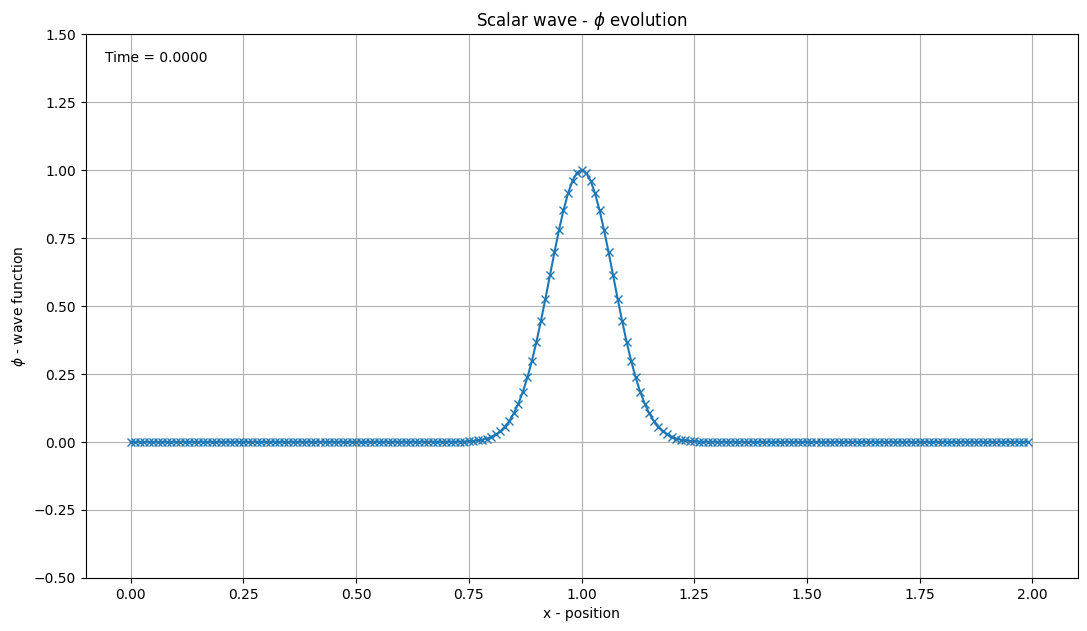

20000


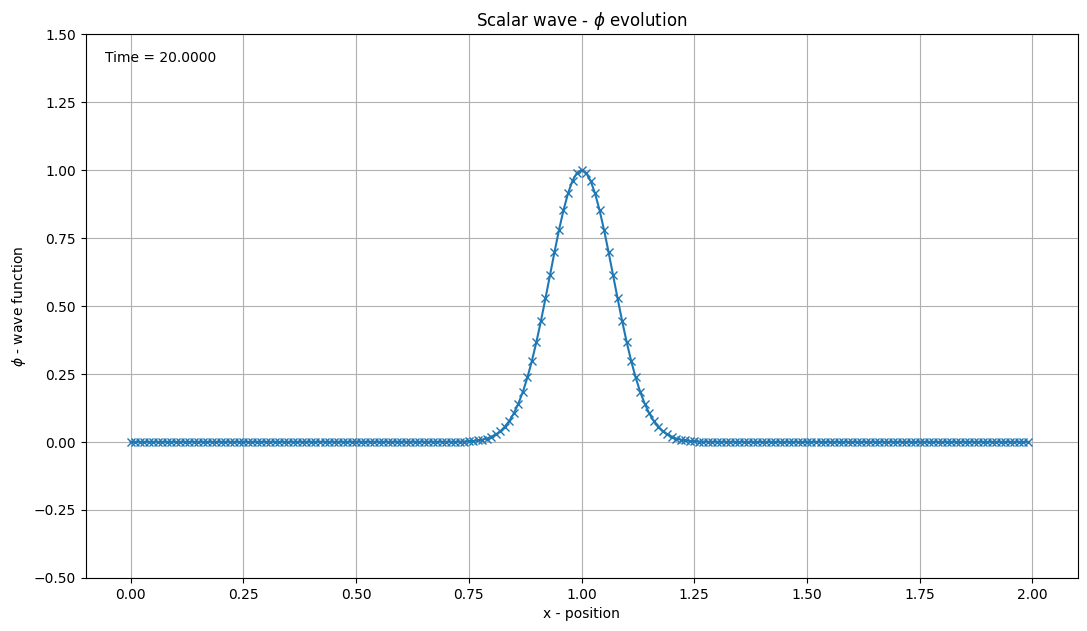

40000


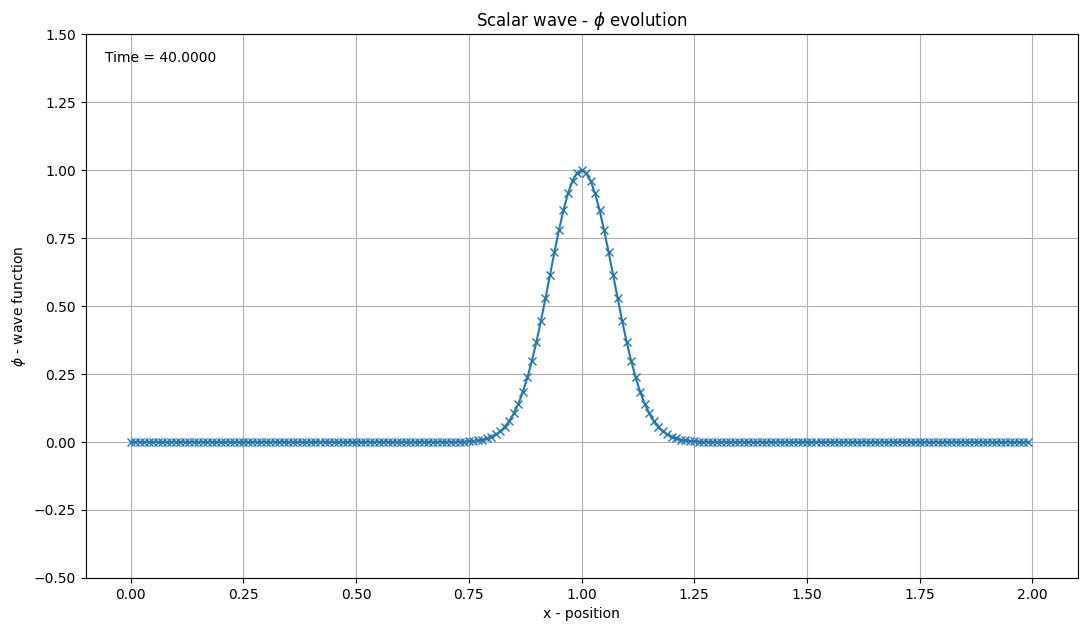

60000


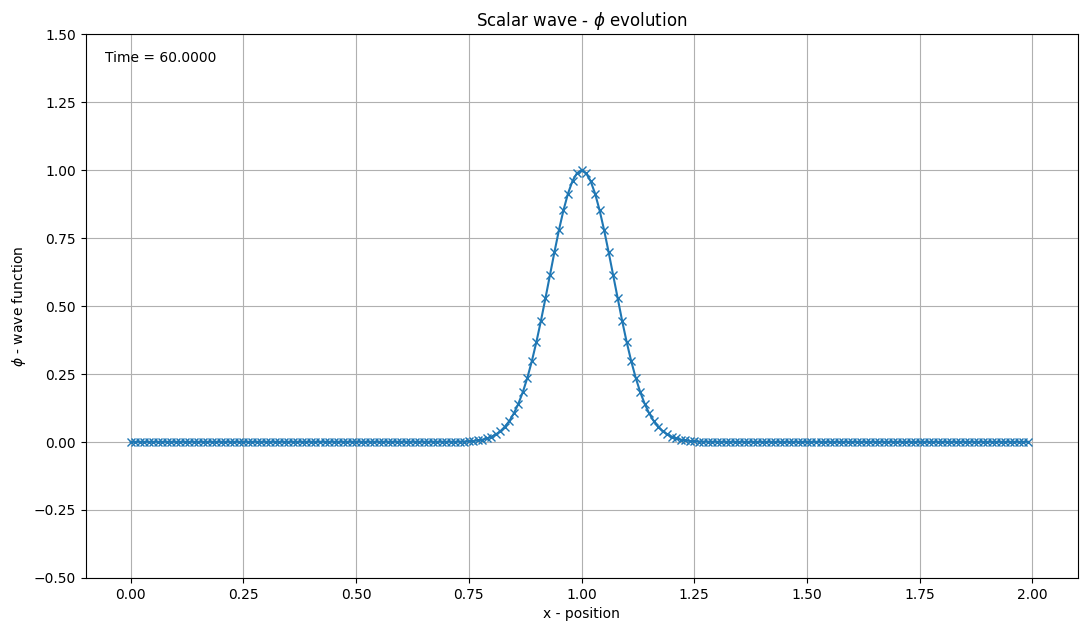

80000


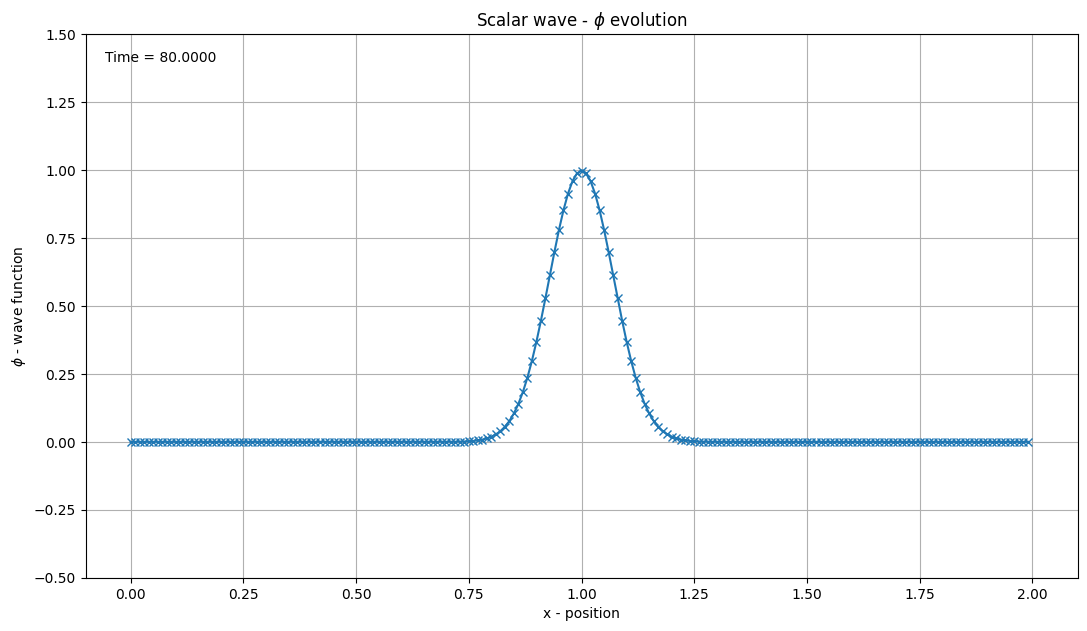

100000


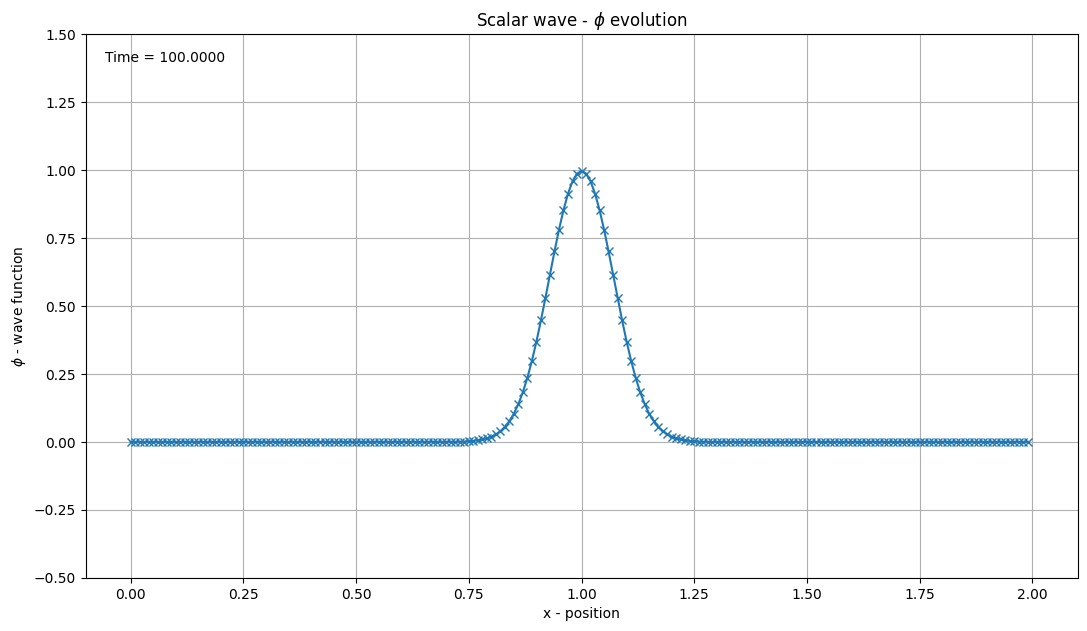

120000


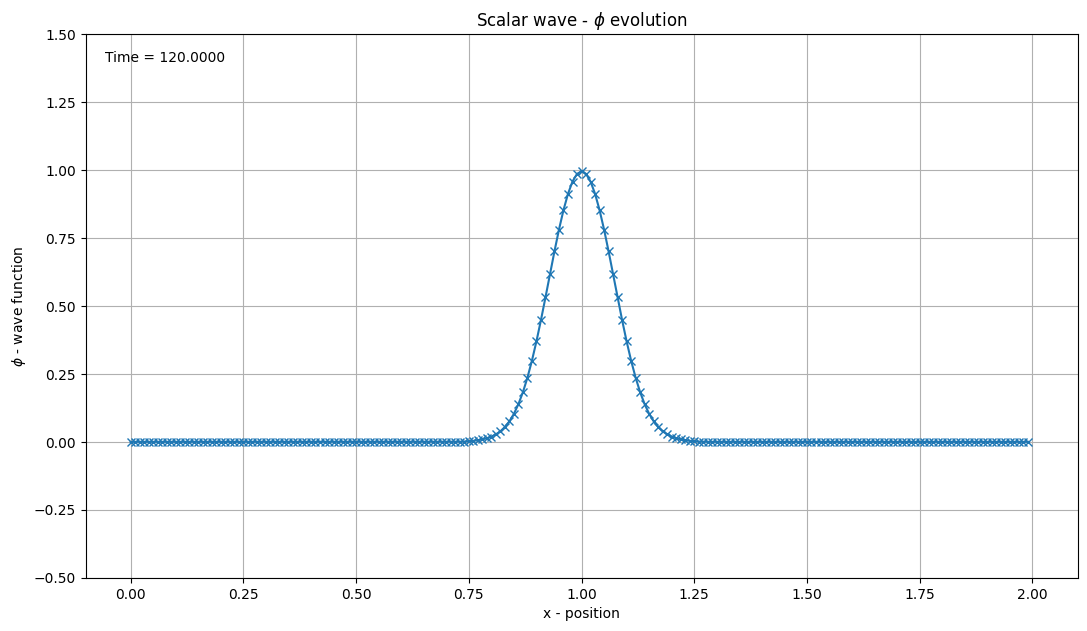

140000


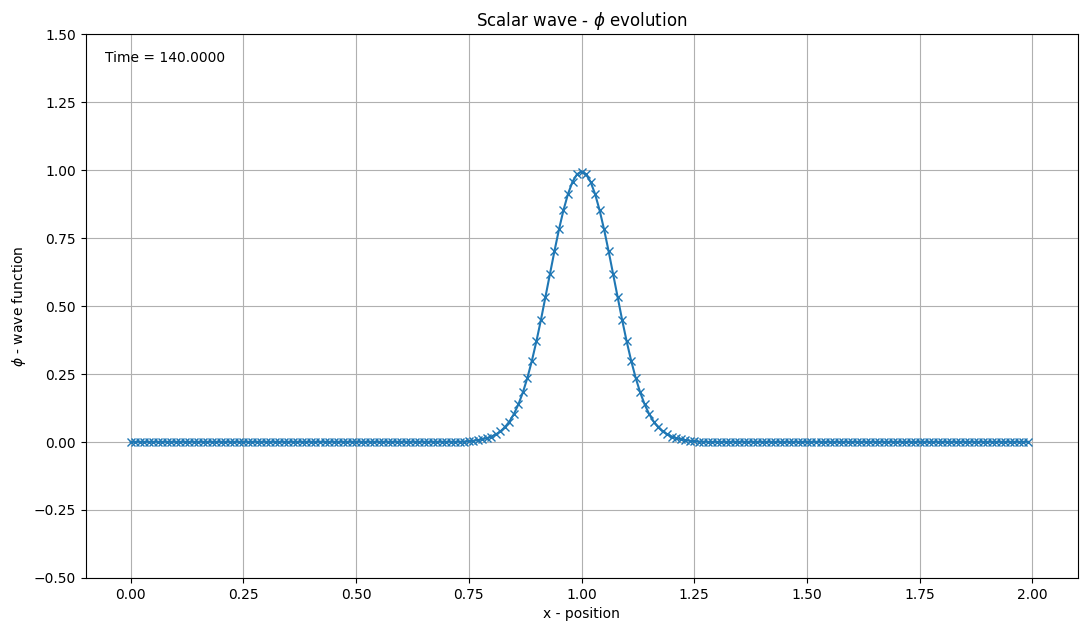

160000


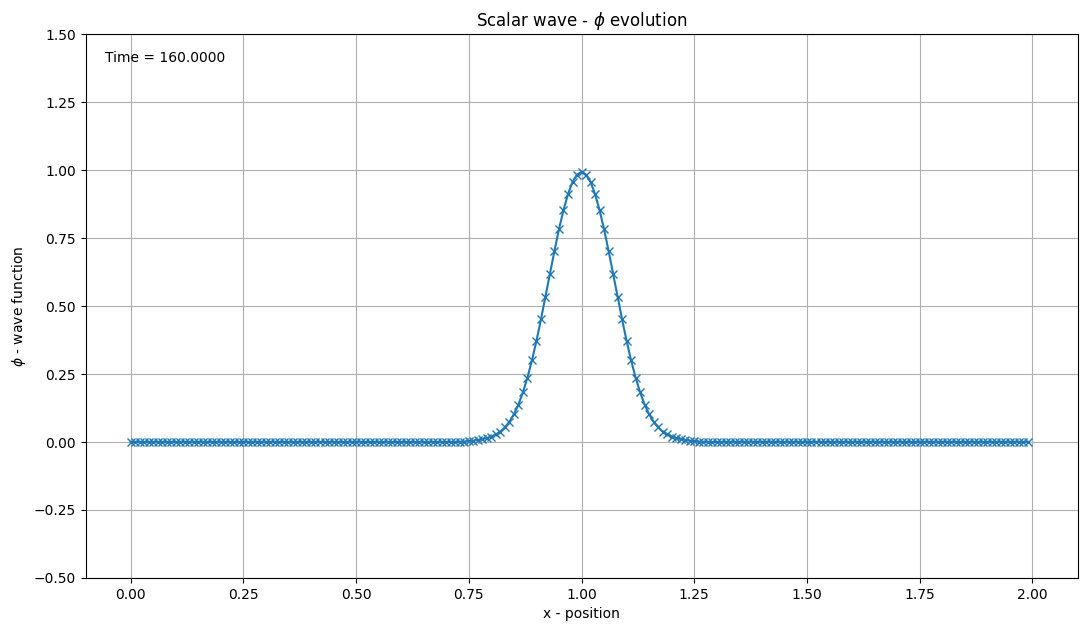

180000


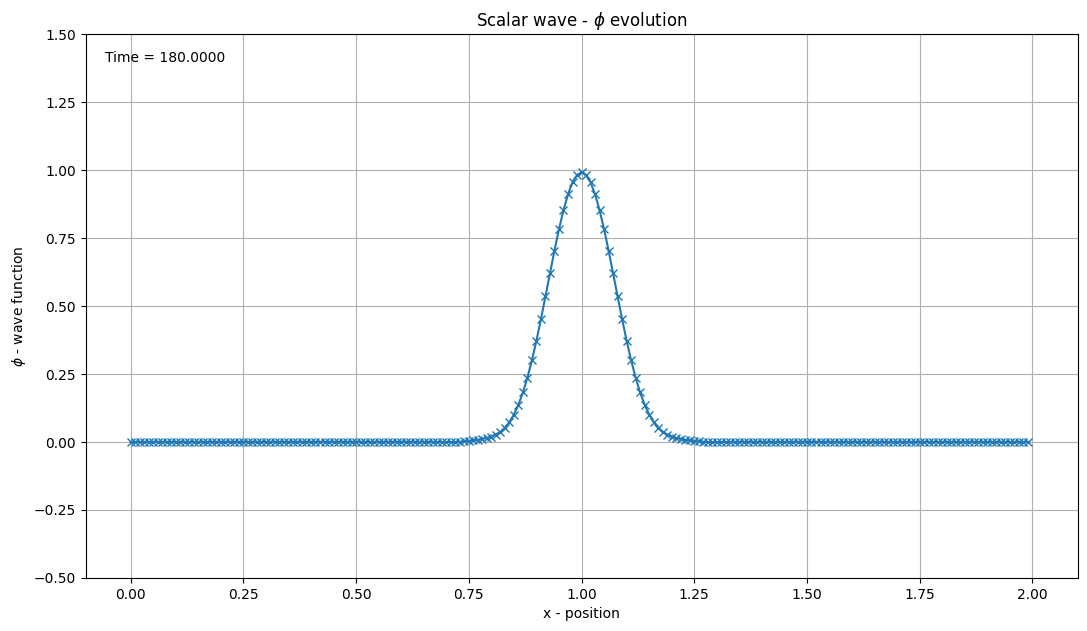

200000


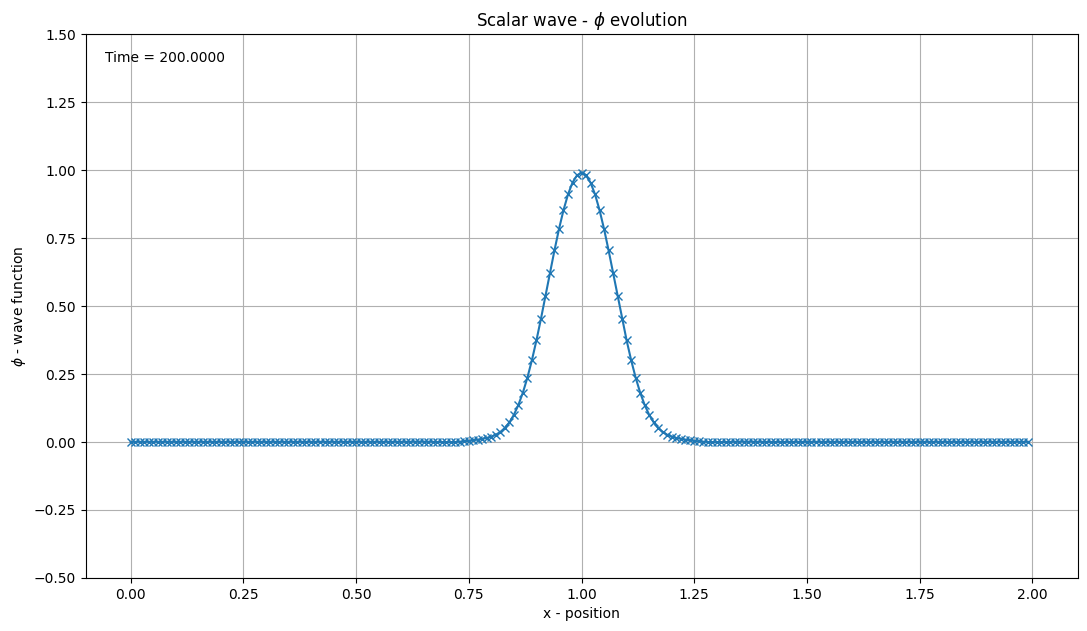

In [14]:
# Quick analysis & plots

phi_result = np.zeros((Nx,Nt))
phi_result = u_result[:,0]

# Plot evolution of wave function
###-------------------------------------------------###
def plot_evolution(title,x_label,y_label,x_param,y_param,i):
    fig_dpi = 100
    fig, ax = plt.subplots(figsize=(1280/fig_dpi,720/fig_dpi),dpi = fig_dpi)
    plt.title(title,fontsize=12)
    plt.xlabel(x_label,fontsize=10)
    plt.ylabel(y_label,fontsize=10)
    ax.axis([-0.1,2.1,-0.5,1.5])
    plt.plot(x_param,y_param,'-x')
    plt.grid(axis="both")
    plt.text(0.02, 0.95, 'Time = %.4f'%var_t[i], transform=ax.transAxes)
    plt.show()
for i in range (0,Nt,int(Nt/10)):
    print(i)
    plot_evolution(r'Scalar wave - $\phi$ evolution',"x - position",r'$\phi$ - wave function',
          var_x,phi_result[i,:],i)
###--------------------------------------------------###

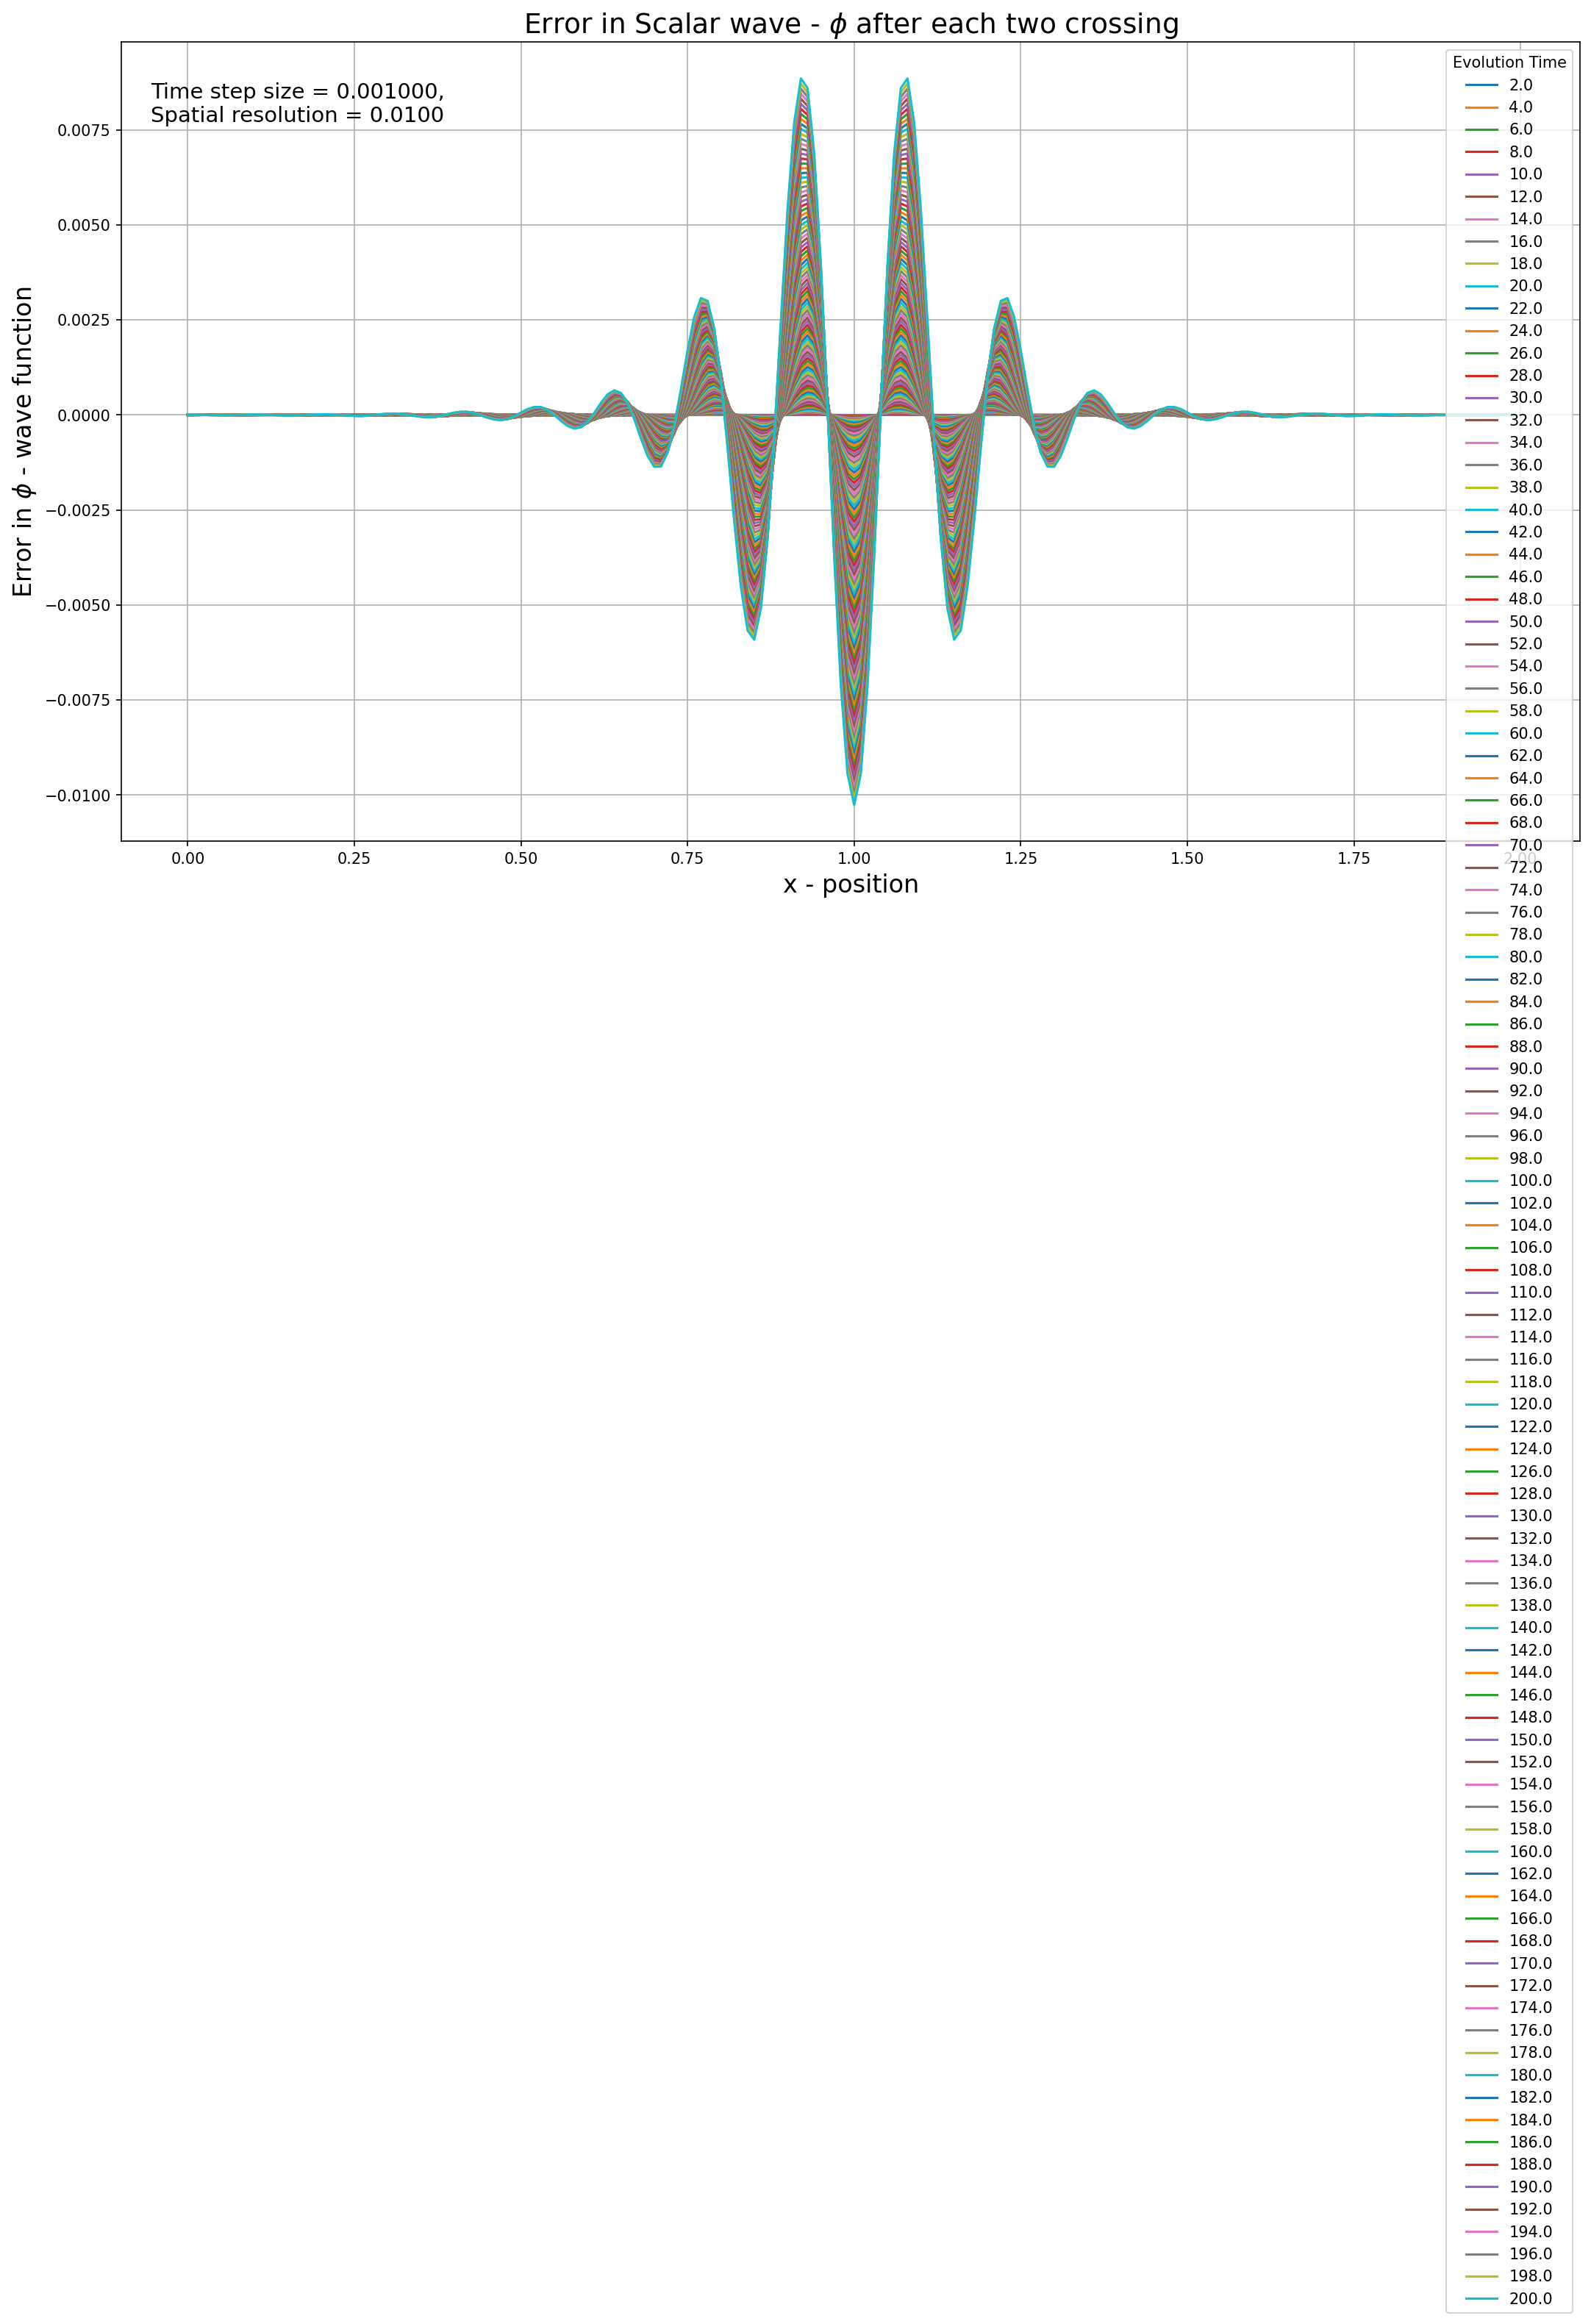

In [15]:
two_full_crossing_time = ( x_start + x_length )
two_full_crossing_iter = (np.where(np.isclose(two_full_crossing_time,var_t,1E-15))[0])[0] # or int(two_full_crossing_time/dt)
if (np.round(var_t[two_full_crossing_iter],15) != two_full_crossing_time):
    print("Exact crossing time does not exists. t[end_point]=%0.4f"%var_t[two_full_crossing_iter])

#Error
total_crossings = int(t_end/two_full_crossing_time - 0)
error = np.zeros((total_crossings,Nx))
crossing_times = np.zeros(total_crossings)
#phi_result[0,:]

j = two_full_crossing_iter
for i in range (len(error)):
    error[i] = phi_result[j] - phi_result[0]
    crossing_times[i] = var_t[j]
    j = j + two_full_crossing_iter
crossing_times = np.round(crossing_times,4)


def plot_crossing_time_error(title,x_label,y_label,x_param,y_param):
    fig_dpi = 150
    fig, ax = plt.subplots(figsize=(2560/fig_dpi,1440/fig_dpi),dpi = fig_dpi)
    plt.title(title,fontsize=18)
    plt.xlabel(x_label,fontsize=16)
    plt.ylabel(y_label,fontsize=16)
    plt.plot(x_param,y_param,label="crossing times")
    plt.legend(crossing_times,title="Evolution Time",loc='upper right')
    plt.text(0.02, 0.90, 'Time step size = %.6f,\nSpatial resolution = %.4f'%(dt,dx),
             transform=ax.transAxes,fontsize=14)
    plt.grid(axis="both")
    plt.show()

plot_crossing_time_error(r'Error in Scalar wave - $\phi$ after each two crossing',
      "x - position",r'Error in $\phi$ - wave function',
      var_x,np.transpose(error))

In [16]:
# #Save phi-data after each two crossings

# ###------------------------------------------------###
# phi_cross = np.zeros((Nx,len(crossing_times)+1))
# phi_cross = np.transpose(phi_cross)
# j = 0
# for i in range (0,int(Nt),int(two_full_crossing_iter)):
#     phi_cross[j] = u_result[:,0][i]
#     j = j+1
# np.save("phi_crossings,Nx=%d,t=(%0.1f,%0.1f),x_s,x_l=(%0.1f,%0.1f)"
#         %(Nx,t_start,t_end,x_start,x_length),phi_cross)
# ###------------------------------------------------###

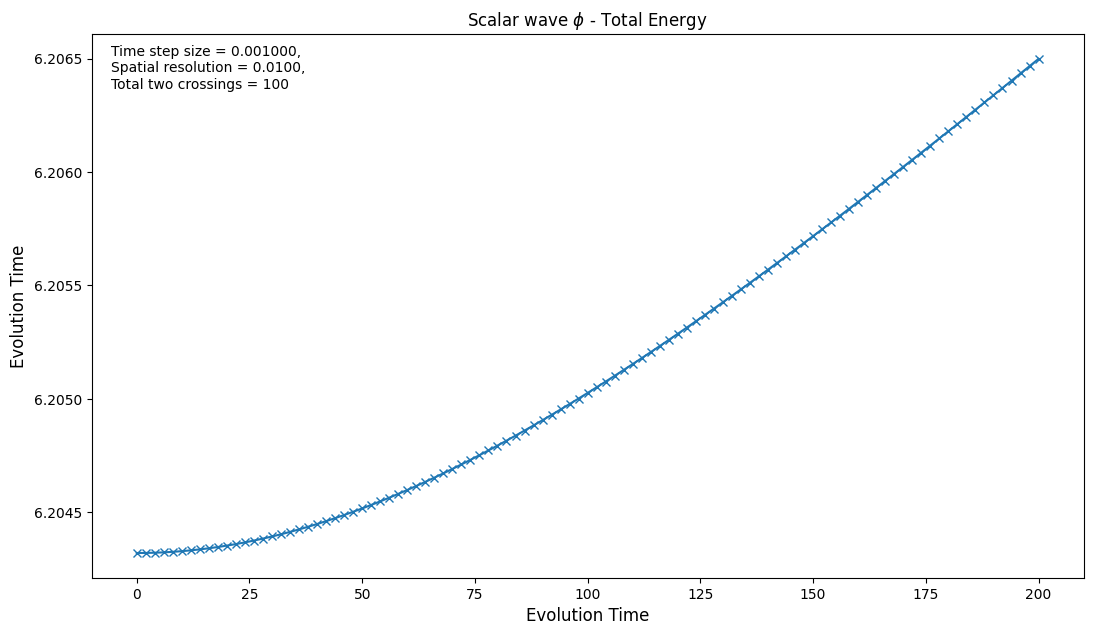

In [17]:
# Test for energy conservation

phi_var = np.zeros((total_crossings+1,Nx))
phi_dot_var = np.zeros((total_crossings+1,Nx))
phi_prime_var = np.zeros((total_crossings+1,Nx))
energy_density = np.zeros((total_crossings+1,Nx))
total_energy = np.zeros((total_crossings+1))

j = 0
for i in range (0,int(Nt),int(two_full_crossing_iter)):
    phi_var[j] = u_result[:,0][i]
    phi_dot_var[j] = u_result[:,1][i]
    j = j+1

# phi_prime -> first order derivative w.r.t 'x' to be computed
def first_order_derivative(var,dx):
    D1_var = np.zeros(Nx)
    var_with_ghosts = exterior_points(var)
    for i in range (1,len(var_with_ghosts)-1):
        # Central finite difference method:
        D1_var[i-1] = (var_with_ghosts[i+1] - var_with_ghosts[i-1])/(2*dx)
    return D1_var

def exterior_points(var):
    var_left_ghost = np.append(var[len(var)-1],var)
    var_ghosts = np.append(var_left_ghost,var[0])
    return var_ghosts

for i in range (total_crossings+1):
    phi_prime_var[i] = first_order_derivative(phi_var[i],dx)
    
# Calculate total energy -> 1/2*phi_dot^2 + 1/2*phi_prime^2

for i in range (total_crossings+1):
    energy_density[i] = 1/2*( (phi_dot_var[i])**2 + (phi_prime_var[i])**2 ) 
    
    
# Calculate energy density -> integrate Energy function along x-axis

# def integrate_simpson(h,param_y): #Ref: https://atozmath.com/example/CONM/NumeInte.aspx?he=e&q=S13
#     t1,t2 = 0,0
#     for i in range (1,len(param_y)-1): 
#         if (i%2 == 1): #odd integers
#             t1 = t1 + param_y[i]
#             #print("t1[i]",i)
#         #print(t1)
#         if (i%2 == 0) : #even integers
#             t2 = t2 + param_y[i]
#             #print("t2[i]",i)
#         #print(t2)
#     integral = (h/3)*(param_y[0] + 4*t1 + 2*t2 + param_y[len(param_y)-1] )
#     return integral

def discrete_pointwise_integration(h,param_y):
    # sum(param_y*dx) over all points
    integral = 0
    for i in range (len(param_y)):
        integral = param_y[i]*h + integral
    return integral


for i in range (total_crossings+1):
    total_energy[i] = discrete_pointwise_integration(dx,energy_density[i])
    
def plot_energy_conservation(title,xlabel,ylabel,x_param,y_param):
    fig_dpi = 100
    fig, ax = plt.subplots(figsize=(1280/fig_dpi,720/fig_dpi),dpi = fig_dpi)
    plt.title(title,fontsize=12)
    plt.xlabel(xlabel,fontsize=12)
    plt.ylabel(xlabel,fontsize=12)
    plt.plot(x_param,y_param,"-x")
    plt.text(0.02, 0.90,
             'Time step size = %.6f,\nSpatial resolution = %.4f,\nTotal two crossings = %d'%
             (dt,dx,total_crossings),
             transform=ax.transAxes,fontsize=10)
    plt.show
    
plot_energy_conservation(r'Scalar wave $\phi$ - Total Energy','Evolution Time',r'Total energy of $\phi$',
                        np.append(0,crossing_times),total_energy)

In [18]:
# # Produce frames to render movie

# import multiprocessing

# def plots(pl):
#     ii = pl[0]
#     fc = pl[1]
#     fig_dpi = 100
#     fig, ax = plt.subplots(figsize=(640/fig_dpi,480/fig_dpi),dpi = fig_dpi)
#     plt.title(r'Scalar wave - $\phi$ evolution',fontsize=12)
#     plt.xlabel("x - position",fontsize=10)
#     plt.ylabel(r'$\phi$ - wave function',fontsize=10)
#     ax.axis([-1.1,+1.1,-1.5,1.5])
#     plt.plot(var_x,phi_result[ii])
#     plt.text(0.02, 0.95, 'Time = %.4f'%var_t[ii], transform=ax.transAxes)
#     plt.savefig("plots_tmp/plot%05d.png"%fc)
#     plt.close(fig)
    
# iter_v = np.arange(0,len(var_t),10) #produce frame every 10 iterations
# frame_count = np.arange(0,len(iter_v),1)
# pl = np.zeros((len(frame_count),2),dtype=int)
# pl[:,0] = iter_v
# pl[:,1] = frame_count
# print("Total number of frames to be rendered: %d"%len(frame_count))

# # multiprocessing to render frames
# pool = multiprocessing.Pool(processes=2) #total 4 procs, 8 threads
# %time pool_return = pool.map(plots,pl)